In [ ]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta
import pytz

from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import pearsonr, spearmanr

nltk.download('vader_lexicon', quiet=True)
plt.rcParams["figure.figsize"] = (10,4)
print("✅ Imports ready")

✅ Imports ready


In [ ]:
# Paths and stock symbols
news_path = "../newsData/raw_analyst_ratings.csv"
stocks_folder = "../yfinance_data/"
stock_symbols = ["AAPL", "AMZN", "MSFT", "GOOG", "META", "NVDA"]

news_df = pd.read_csv(news_path, parse_dates=["date"])
print("News rows:", len(news_df))

prices_dict = {}
for symbol in stock_symbols:
    file_path = os.path.join(stocks_folder, f"{symbol}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["Date"])
        df.columns = [c.lower() for c in df.columns]  
        df = df.sort_values('date').reset_index(drop=True)
        prices_dict[symbol] = df
        print(f"{symbol} rows:", len(df))
    else:
        print(f"File not found for {symbol}")


News rows: 1407328
AAPL rows: 3774
AMZN rows: 3774
MSFT rows: 3774
GOOG rows: 3774
META rows: 2923
NVDA rows: 3774


In [ ]:
# Normalize news and prices columns
news_df.columns = news_df.columns.str.strip()
news_df['headline'] = news_df['headline'].astype(str)

for sym, df in prices_dict.items():
    if 'close' not in df.columns:
        if 'Close' in df.columns:
            df.rename(columns={'Close':'close'}, inplace=True)
    prices_dict[sym] = df

In [ ]:
# Map News timestamps to trading dates
exchange_tz = pytz.timezone("US/Eastern")
market_close_time = time(16, 0)

news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df = news_df.dropna(subset=['date'])
if news_df['date'].dt.tz is None:
    news_df['date'] = news_df['date'].dt.tz_localize('UTC')
news_df['date_local'] = news_df['date'].dt.tz_convert('US/Eastern')

def map_to_trading_date(ts_local):
    dt = ts_local
    while dt.weekday() >= 5:
        dt += pd.Timedelta(days=1)
    if dt.time() >= market_close_time:
        dt += pd.Timedelta(days=1)
        while dt.weekday() >= 5:
            dt += pd.Timedelta(days=1)
    return dt.normalize().date()

news_df['trading_date'] = news_df['date_local'].apply(map_to_trading_date)
print(news_df[['date_local','trading_date']].head(5))

                 date_local trading_date
0 2020-06-05 10:30:54-04:00   2020-06-05
1 2020-06-03 10:45:20-04:00   2020-06-03
2 2020-05-26 04:30:07-04:00   2020-05-26
3 2020-05-22 12:45:06-04:00   2020-05-22
4 2020-05-22 11:38:59-04:00   2020-05-22


In [ ]:
# Sentiment analysis
sid = SentimentIntensityAnalyzer()
news_df['vader_compound'] = news_df['headline'].apply(lambda t: sid.polarity_scores(t)['compound'])
news_df['textblob_polarity'] = news_df['headline'].apply(lambda t: TextBlob(t).sentiment.polarity)

news_df['sentiment_score'] = news_df['vader_compound']
news_df[['headline','trading_date','sentiment_score']].head(5)

,headline,trading_date,sentiment_score
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,0.000
2,71 Biggest Movers From Friday,2020-05-26,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,0.000
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,0.296


In [ ]:
# Sentiment analysis
sid = SentimentIntensityAnalyzer()
news_df['vader_compound'] = news_df['headline'].apply(lambda t: sid.polarity_scores(t)['compound'])
news_df['textblob_polarity'] = news_df['headline'].apply(lambda t: TextBlob(t).sentiment.polarity)

news_df['sentiment_score'] = news_df['vader_compound']
news_df[['headline','trading_date','sentiment_score']].head(5)

,headline,trading_date,sentiment_score
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,0.000
2,71 Biggest Movers From Friday,2020-05-26,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,0.000
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,0.296


In [ ]:
# Prepare prices, compute returns, merge with sentiment (all tickers)
merged_data = {}

for sym, prices_df in prices_dict.items():
    prices_df = prices_df.copy()
    prices_df['date'] = pd.to_datetime(prices_df['date']).dt.date
    prices_df = prices_df.sort_values('date')
    
        prices_df['daily_return'] = prices_df['close'].pct_change()
    prices_df['log_return'] = np.log(prices_df['close']).diff()
    
    if sym in daily_sentiments:
        daily_sent = daily_sentiments[sym].copy()
        merged = pd.merge(prices_df, daily_sent, on='date', how='left')
        merged['avg_sentiment_filled'] = merged['avg_sentiment'].fillna(0)
    else:
        merged = prices_df.copy()
        merged['avg_sentiment_filled'] = 0
    merged_data[sym] = merged
    
        print(f"{sym} merged data:")
    display(merged.head(6))

AAPL merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment,avg_sentiment_filled
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,NaN,NaN,NaN,0.0
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,0.042204,0.041338,NaN,0.0
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,-0.016494,-0.016632,NaN,0.0
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,-0.021609,-0.021845,NaN,0.0
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,0.018570,0.018399,NaN,0.0
5,2009-01-09,2.716589,2.800564,2.703393,2.795466,546845600,-0.022869,-0.023135,NaN,0.0


AMZN merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment,avg_sentiment_filled
0,2009-01-02,2.7180,2.7265,2.5535,2.5675,145928000,NaN,NaN,NaN,0.0
1,2009-01-05,2.7030,2.7870,2.6515,2.7865,190196000,-0.005519,-0.005534,NaN,0.0
2,2009-01-06,2.8680,2.9110,2.6875,2.7275,221602000,0.061043,0.059253,NaN,0.0
3,2009-01-07,2.8100,2.8475,2.7675,2.8145,158854000,-0.020223,-0.020430,NaN,0.0
4,2009-01-08,2.8580,2.8660,2.7290,2.7495,131558000,0.017082,0.016938,NaN,0.0
5,2009-01-09,2.7755,2.8500,2.7350,2.8460,133682000,-0.028866,-0.029291,NaN,0.0


MSFT merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment_filled
0,2009-01-02,14.872976,14.924187,14.170662,14.287715,50084000,NaN,NaN,0
1,2009-01-05,15.011971,15.121707,14.675444,14.777866,61475200,0.009345,0.009302,0
2,2009-01-06,15.187551,15.363130,15.077815,15.180236,58083400,0.011696,0.011628,0
3,2009-01-07,14.273087,14.843718,14.251139,14.770560,72709900,-0.060211,-0.062100,0
4,2009-01-08,14.719351,14.770561,14.302350,14.360876,70255400,0.031266,0.030787,0
5,2009-01-09,14.280397,14.851027,14.199923,14.755923,49815300,-0.029822,-0.030275,0


GOOG merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment,avg_sentiment_filled
0,2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322,NaN,NaN,NaN,0.0
1,2009-01-05,8.115089,8.194003,7.792268,7.940692,196293007,0.020945,0.020728,NaN,0.0
2,2009-01-06,8.263762,8.430492,8.074027,8.237046,257971329,0.018321,0.018155,NaN,0.0
3,2009-01-07,7.965677,8.185839,7.885034,8.121770,180453860,-0.036071,-0.036738,NaN,0.0
4,2009-01-08,8.044340,8.044340,7.850152,7.873406,144567852,0.009875,0.009827,NaN,0.0
5,2009-01-09,7.794000,8.101486,7.752688,8.101486,174270770,-0.031120,-0.031615,NaN,0.0


META merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment_filled
0,2012-05-18,37.995762,44.724282,37.767172,41.792356,573576400,NaN,NaN,0
1,2012-05-21,33.821495,36.435382,32.797807,36.306177,168192700,-0.109861,-0.116378,0
2,2012-05-22,30.810066,33.384198,30.750434,32.410203,101786600,-0.089039,-0.093255,0
3,2012-05-23,31.803938,32.300874,31.167860,31.177799,73600000,0.032258,0.031749,0
4,2012-05-24,32.827625,33.006523,31.575347,32.748117,50237200,0.032187,0.031680,0
5,2012-05-25,31.714489,32.748118,30.919391,32.698425,37149800,-0.033909,-0.034497,0


NVDA merged data:


,date,close,high,low,open,volume,daily_return,log_return,avg_sentiment,avg_sentiment_filled
0,2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,NaN,NaN,NaN,0.0
1,2009-01-05,0.203319,0.207904,0.195984,0.197360,705736000,0.018370,0.018203,NaN,0.0
2,2009-01-06,0.210196,0.216156,0.204695,0.209279,657904000,0.033822,0.033263,NaN,0.0
3,2009-01-07,0.197589,0.205382,0.190483,0.205382,870096000,-0.059978,-0.061852,NaN,0.0
4,2009-01-08,0.192546,0.195067,0.180626,0.195067,1014496000,-0.025522,-0.025854,NaN,0.0
5,2009-01-09,0.181773,0.192546,0.181314,0.192546,761352000,-0.055952,-0.057578,NaN,0.0


In [ ]:
# Aggregate daily sentiment per stock
daily_sentiments = {}
for sym in stock_symbols:
    news_sym = news_df[news_df['stock'].str.upper() == sym].copy()
    if news_sym.empty:
        continue
    daily_sent = news_sym.groupby('trading_date')['sentiment_score'] \
                         .mean().reset_index().rename(columns={'trading_date':'date', 'sentiment_score':'avg_sentiment'})
    daily_sentiments[sym] = daily_sent


In [ ]:
# Compute stock returns and merge with sentiment
merged_data = {}
for sym, df in prices_dict.items():
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.sort_values('date')
    df['daily_return'] = df['close'].pct_change()
    
    if sym in daily_sentiments:
        daily_sent = daily_sentiments[sym]
        merged = pd.merge(df, daily_sent, on='date', how='left')
        merged['avg_sentiment_filled'] = merged['avg_sentiment'].fillna(0) 
        merged_data[sym] = merged


In [ ]:
#Correlation analysis
results = []
for sym, merged in merged_data.items():
    d = merged.dropna(subset=['avg_sentiment_filled','daily_return'])
    if len(d) >= 5:
        r, p = pearsonr(d['avg_sentiment_filled'], d['daily_return'])
    else:
        r, p = np.nan, np.nan
    
    merged = merged.sort_values('date')
    merged['return_t_plus_1'] = merged['daily_return'].shift(-1)
    d1 = merged.dropna(subset=['avg_sentiment_filled','return_t_plus_1'])
    if len(d1) >= 5:
        r1, p1 = pearsonr(d1['avg_sentiment_filled'], d1['return_t_plus_1'])
    else:
        r1, p1 = np.nan, np.nan
    
    results.append({'ticker':sym, 'n_days':len(d), 'same_day_r':r, 'same_day_p':p, 'lagged_r':r1, 'lagged_p':p1})

results_df = pd.DataFrame(results).sort_values('same_day_r', ascending=False)
results_df

,ticker,n_days,same_day_r,same_day_p,lagged_r,lagged_p
0,AAPL,3773,0.035194,0.030639,-0.010752,0.509096
1,AMZN,3773,0.016391,0.314161,-0.023270,0.152975
3,NVDA,3773,0.012407,0.446138,0.007255,0.655974
2,GOOG,3773,-0.003734,0.818628,-0.014778,0.364165


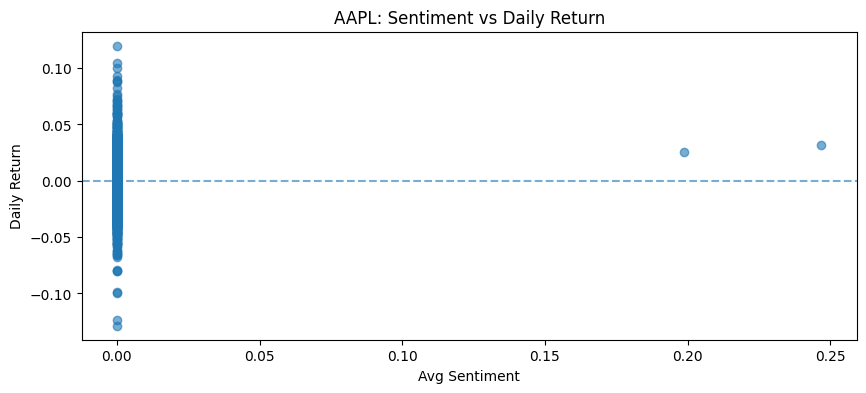

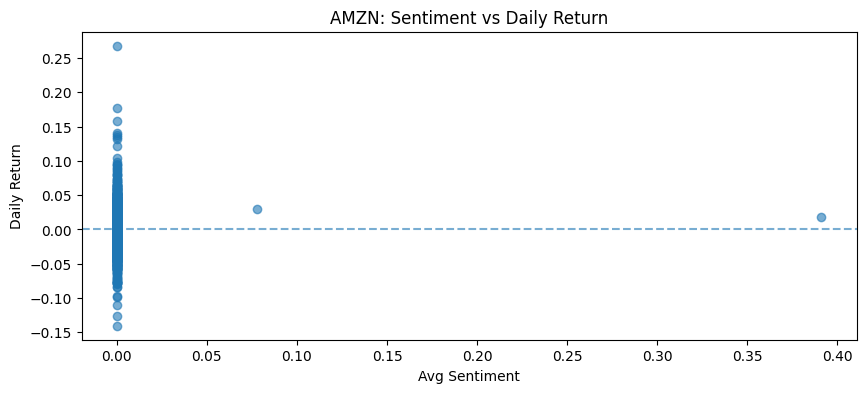

No data to plot for MSFT


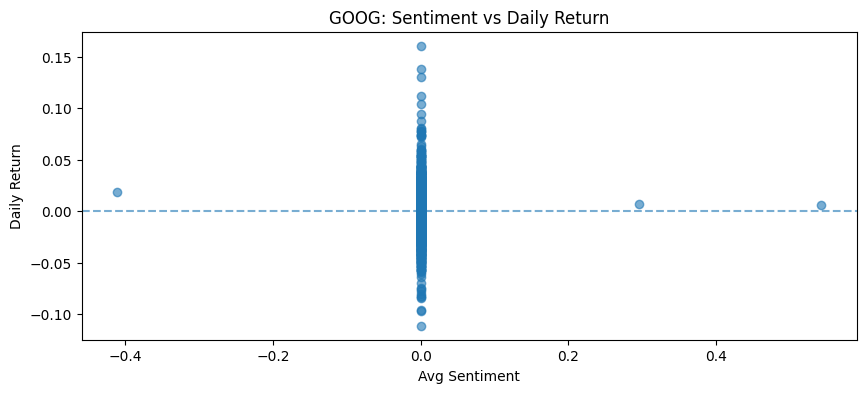

No data to plot for META


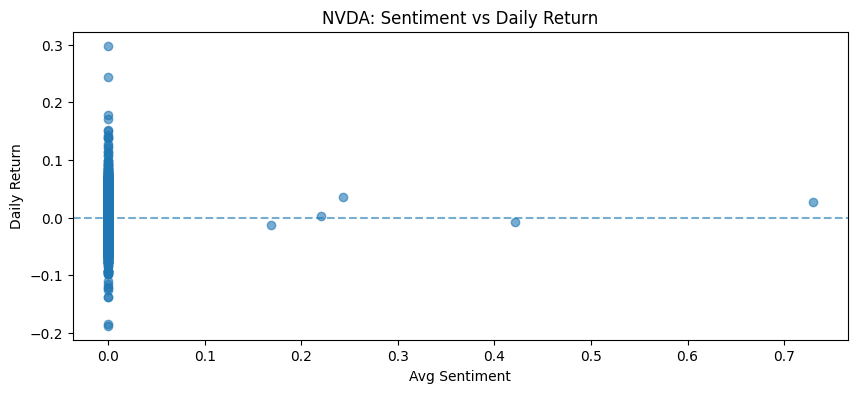

In [ ]:
#Scatter & time-series plots for all tickers (fixed)
for sym in stock_symbols:
    merged = merged_data.get(sym, pd.DataFrame())
    
    if merged.empty:
        print(f"No data to plot for {sym}")
        continue

    merged_plot = merged.dropna(subset=['avg_sentiment_filled','daily_return'], how='all')
    if merged_plot.empty:
        print(f"No valid sentiment/returns for {sym}")
        continue

    # Scatter plot
    plt.figure()
    plt.scatter(merged_plot['avg_sentiment_filled'], merged_plot['daily_return'], alpha=0.6)
    m, b = np.polyfit(merged_plot['avg_sentiment_filled'], merged_plot['daily_return'], 1)
    xs = np.linspace(merged_plot['avg_sentiment_filled'].min(), merged_plot['avg_sentiment_filled'].max(), 50)
    plt.plot(xs, m*xs + b, color='red')
    plt.xlabel('Avg Sentiment')
    plt.ylabel('Daily Return')
    plt.title(f"{sym}: Sentiment vs Daily Return")
    plt.axhline(0, linestyle='--', alpha=0.6)
    plt.show()



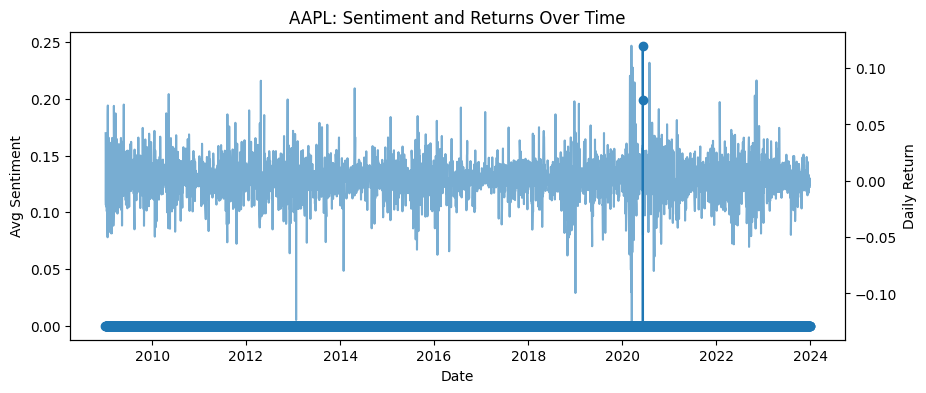

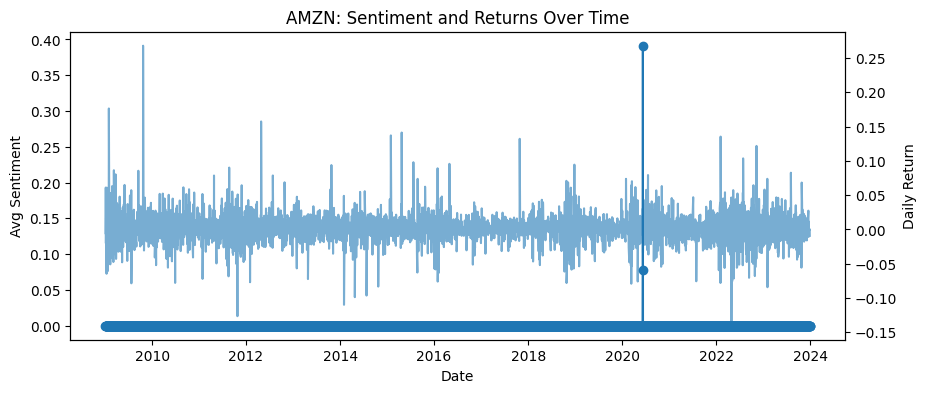

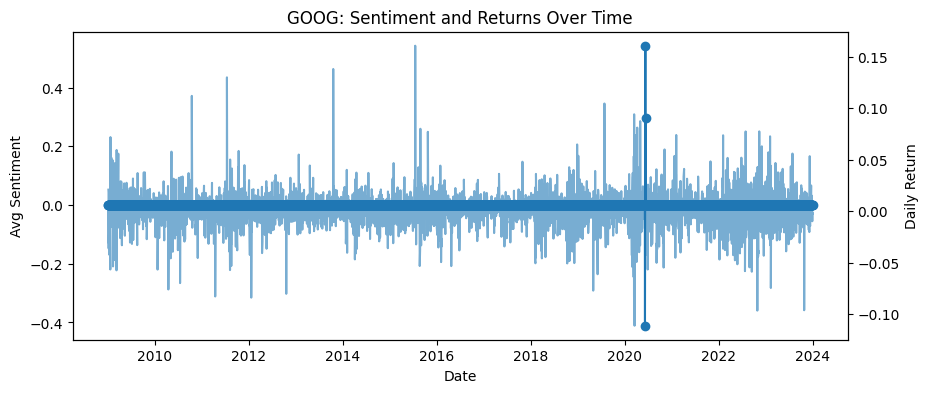

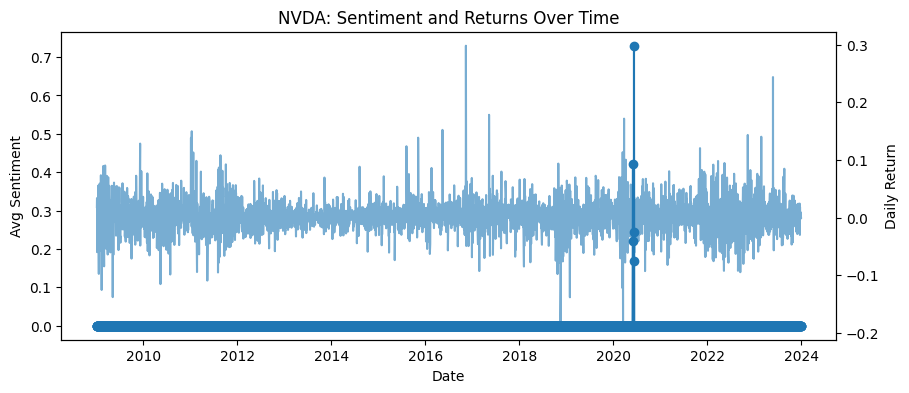

In [ ]:
# Iterative time-series plots for all tickers
for sym, merged in merged_data.items():
    if merged.empty:
        continue
    
    merged_plot = merged.dropna(subset=['avg_sentiment_filled','daily_return'], how='all')

    fig, ax = plt.subplots()
    ax.plot(merged_plot['date'], merged_plot['avg_sentiment_filled'], label='Avg Sentiment', marker='o')
    ax2 = ax.twinx()
    ax2.plot(merged_plot['date'], merged_plot['daily_return'], label='Daily Return', alpha=0.6)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Avg Sentiment')
    ax2.set_ylabel('Daily Return')
    
    plt.title(f"{sym}: Sentiment and Returns Over Time")
    plt.show()


In [ ]:
# Prepare DataFrames for correlation heatmaps
returns_dict = {}
sentiment_dict = {}

for sym, merged in merged_data.items():
    merged_sorted = merged.sort_values('date').copy()
    returns_dict[sym] = merged_sorted['daily_return'].values
    sentiment_dict[sym] = merged_sorted['avg_sentiment_filled'].values

# Create DataFrames
returns_df = pd.DataFrame(returns_dict)
sentiment_df = pd.DataFrame(sentiment_dict)
df_corr = pd.concat([returns_df.add_suffix('_return'), sentiment_df.add_suffix('_sentiment')], axis=1)


In [115]:
# Pearson correlation matrix
pearson_corr = df_corr.corr(method="pearson")
print("Pearson correlation matrix:")
print(pearson_corr)

# Spearman correlation matrix
spearman_corr = df_corr.corr(method="spearman")
print("\nSpearman correlation matrix:")
print(spearman_corr)

# Kendall correlation matrix
kendall_corr = df_corr.corr(method="kendall")
print("\nKendall correlation matrix:")
print(kendall_corr)


Pearson correlation matrix:
                AAPL_return  AMZN_return  GOOG_return  NVDA_return  \
AAPL_return        1.000000     0.472398     0.570600     0.506192   
AMZN_return        0.472398     1.000000     0.581239     0.447627   
GOOG_return        0.570600     0.581239     1.000000     0.512466   
NVDA_return        0.506192     0.447627     0.512466     1.000000   
AAPL_sentiment     0.035194     0.024697     0.007550     0.023046   
AMZN_sentiment     0.027014     0.016391     0.006336     0.021348   
GOOG_sentiment    -0.001754     0.010022    -0.003734    -0.003415   
NVDA_sentiment     0.033629     0.026037     0.007938     0.012407   

                AAPL_sentiment  AMZN_sentiment  GOOG_sentiment  NVDA_sentiment  
AAPL_return           0.035194        0.027014       -0.001754        0.033629  
AMZN_return           0.024697        0.016391        0.010022        0.026037  
GOOG_return           0.007550        0.006336       -0.003734        0.007938  
NVDA_return      

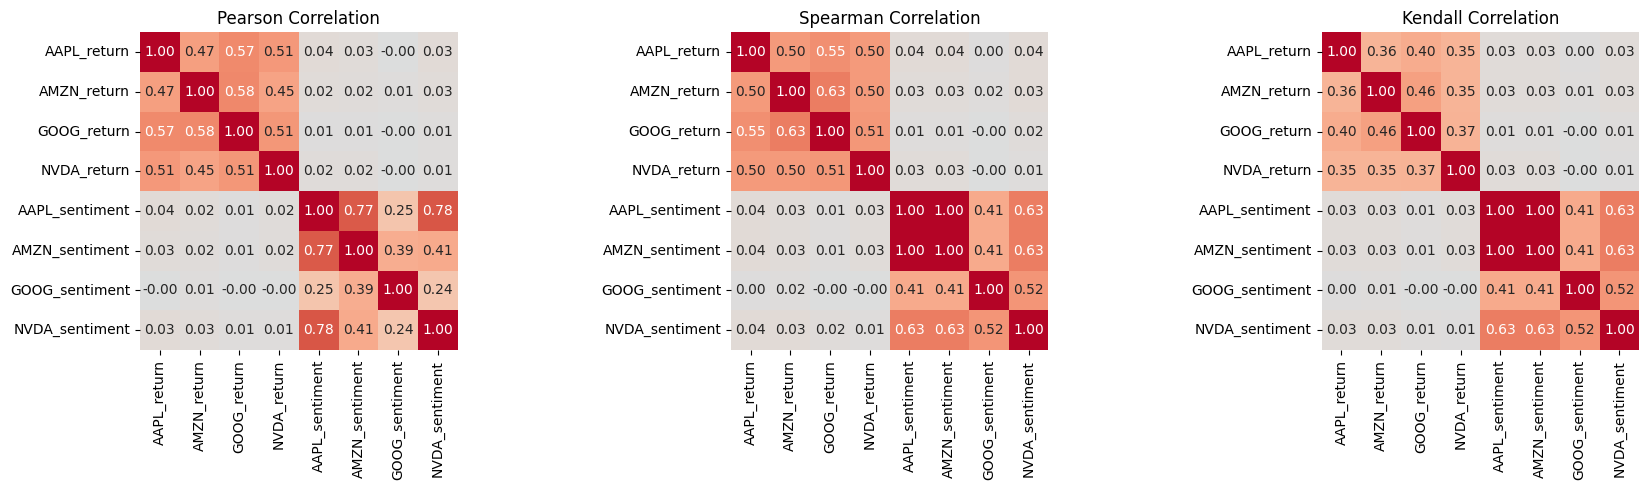

In [ ]:
# CORRELATION HEATMAPS
corr_methods = {
    "Pearson": df_corr.corr(method="pearson"),
    "Spearman": df_corr.corr(method="spearman"),
    "Kendall": df_corr.corr(method="kendall"),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (title, corr) in zip(axes, corr_methods.items()):
    sns.heatmap(corr, ax=ax, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", square=True, cbar=False)
    ax.set_title(f"{title} Correlation")

fig.tight_layout()
plt.show()